<a href="https://colab.research.google.com/github/Mostafa3zazi/CISC-873-DM-Data-Mining/blob/main/CISC_873_DM_F22_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CISC-873-DM-F22-A2: Whether a first date will lead to a relationship

#Download data form kaggel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install kaggle --upgrade

In [ ]:
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle --version

Kaggle API 1.5.4


In [ ]:
!kaggle competitions download -c cisc-873-dm-f22-a2

  0% 0.00/202k [00:00<?, ?B/s]
100% 202k/202k [00:00<00:00, 77.1MB/s]
  0% 0.00/942k [00:00<?, ?B/s]
100% 942k/942k [00:00<00:00, 62.4MB/s]
  0% 0.00/391k [00:00<?, ?B/s]
100% 391k/391k [00:00<00:00, 127MB/s]


In [ ]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


#install required packages

In [ ]:
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 3.3 MB/s 


#inspecting training data

In [ ]:
#import libraries for data exploration and processing
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
#read train and test files
df_train_original = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
df_train_original.head()

,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,...,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3,id
0,0,3,2,14,18,2,2.0,14,12,372.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2583
1,1,14,1,3,10,2,NaN,8,8,63.0,...,8.0,8.0,7.0,8.0,NaN,NaN,NaN,NaN,NaN,6830
2,1,14,1,13,10,8,8.0,10,10,331.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4840
3,1,38,2,9,20,18,13.0,6,7,200.0,...,9.0,8.0,8.0,6.0,NaN,NaN,NaN,NaN,NaN,5508
4,1,24,2,14,20,6,6.0,20,17,357.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4828


I have read the speed dating describtion PDF and came up with these findings:

1. there are some columns that are not relivant to our taks and should be dropped : [ 'id', 'idg', 'partner', 'pid', 'zipcode' ]
2. redundant columns:
[ 'field', 'career' ] (we can encode career_c and field_cd instade)

In [ ]:
df_train = df_train_original.copy()

In [ ]:
non_relivant_columns =  [ 'id', 'idg', 'partner', 'pid', 'zipcode' ]
redundant_columns = [ 'field', 'career' ]
df_train.drop(non_relivant_columns + redundant_columns , inplace = True,axis = 1)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Columns: 185 entries, gender to amb5_3
dtypes: float64(172), int64(8), object(5)
memory usage: 8.3+ MB


there are 5 catigorical data with string (object) values ... let's find them and see how to preprocess them.

In [ ]:
objcet_columns = df_train.select_dtypes(include=['object'], exclude=None).columns
objcet_columns

Index(['undergra', 'mn_sat', 'tuition', 'from', 'income'], dtype='object')

In [ ]:
df_train[objcet_columns]

,undergra,mn_sat,tuition,from,income
0,University of Michigan-Ann Arbor,"1,290.00","21,645.00","Palo Alto, CA",NaN
1,NaN,NaN,NaN,"Boston, MA",NaN
2,"Rizvi College of Architecture, Bombay University",NaN,NaN,"Bombay, India",NaN
3,NaN,NaN,NaN,"Washington, DC","45,300.00"
4,Harvard College,"1,400.00","26,019.00",Midwest USA,"46,138.00"
...,...,...,...,...,...
5904,NaN,NaN,NaN,New York,"65,708.00"
5905,NaN,NaN,NaN,Colombia,NaN
5906,University of Washington,"1,155.00","13,258.00",Seattle,"37,881.00"
5907,NaN,NaN,NaN,Canada,NaN


there are 3 columns that can be converted to numeric values [ 'mn_sat', 'tuition', 'income' ]

In [ ]:
obj_num_col = [ 'mn_sat', 'tuition', 'income' ]
df_train[obj_num_col] = df_train[obj_num_col].apply(
    lambda x: x.str.replace(',', '').astype(float),
    axis = 1)
df_train[obj_num_col]

,mn_sat,tuition,income
0,1290.0,21645.0,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,45300.0
4,1400.0,26019.0,46138.0
...,...,...,...
5904,NaN,NaN,65708.0
5905,NaN,NaN,NaN
5906,1155.0,13258.0,37881.0
5907,NaN,NaN,NaN


check if we can encode the rest columns [ 'undergra', 'from' ]

In [ ]:
df_train['undergra'].value_counts()

Harvard                               82
UC Berkeley                           78
Columbia                              72
Yale                                  60
NYU                                   51
                                      ..
National University Of Singapore       4
oberlin                                4
University of Rochester                3
Universidad Catolica de Chile          3
Fu Jen Catholic University, Taiwan     3
Name: undergra, Length: 241, dtype: int64

In [ ]:
df_train['from'].value_counts()

New York            368
New Jersey          246
California          211
China               104
New York City        94
                   ... 
china                 4
sofia, bg             3
Upstate New York      3
Greenwich, CT         2
Europe                2
Name: from, Length: 269, dtype: int64

So many unique values, is we uesed onehot encoding the result set will contain huge number of columns so we will drop them.

In [ ]:
df_train.drop(['undergra','from'] , inplace = True,axis = 1)

In [ ]:
#check for nan values
df_train.isna().sum()

gender         0
condtn         0
wave           0
round          0
position       0
            ... 
attr5_3     4496
sinc5_3     4496
intel5_3    4496
fun5_3      4496
amb5_3      4496
Length: 183, dtype: int64

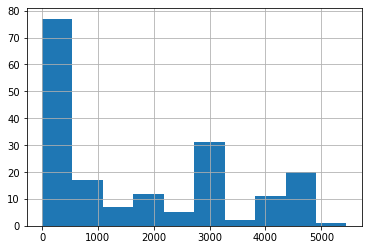

In [ ]:
df_train.isna().sum().hist();

so many nan values

In [ ]:
#check duplicated
df_train.duplicated().sum()

0

#Problem Formulation
the objective is to predict the outcome of a specific speed dating session based on the profile of two people, so we can implement a recommendation system to better match people in speed dating events.

the input is: a data sample (information about the dating session)

the output is:  predict the probability (0-1, float) that the dating session will lead to a successful match.

this is a binary Classification in which we predict a probability using ROCAUC as the evaluation metric. The main challenge is that the data contains missing values, catigorical, and nominal data. we can handel the missing values by dropping them (if we do so we will drop more than half of our data) so we need to find the best way to fill these value (using mean or average). Three different search algorithms will be used for hyperparameter optimization (Grid Search, Random Search, and Bayesian search). and different models will be used (xgboost , SVM , decission tree). the ideal solution would be fining the best stratigy to replace null vlaues and the optimal hyperparameters for the suitable model. the impact is that we will have a powerfull model to be used in future dating session so that we can match the best partners together.



#Preprocessing Data pipeline

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin,BaseEstimator
from skopt.space import Real, Categorical, Integer

In [ ]:
# #nominal columns
# nominal_columns = ['wave' , 'position' , 'positin1' , 'order' , 'race_o' , 'field_cd' , 
#                    'race' , 'goal' , 'date' , 'go_out' , 'career_c' , 'length' , 'numdat_2','round']
# df_train = pd.get_dummies(df_train, prefix = nominal_columns, columns = nominal_columns)

In [ ]:
# df_train_trial0 = df_train.copy()

In [ ]:
class pandas_fill_na(BaseEstimator, TransformerMixin):
  def __init__(self, fill_type):
      self.fill_type = fill_type
  def fit(self, X, y=None):
      return self
  def transform(self, X):
      assert isinstance(X, pd.DataFrame)
      if self.fill_type is 'mean':
        return X.fillna(X.mean())
      if self.fill_type is 'median':
        return X.fillna(X.median())
      # if self.fill_type is 'mode':
      #   return X.fillna(X.mode())

In [ ]:
# x.fillna(x.mode()).isna().sum().sum()

In [ ]:
class pandas_get_dummies(BaseEstimator, TransformerMixin):
  def __init__(self, nominal_columns):
      self.nominal_columns = nominal_columns
  def fit(self, X, y=None):
      return self
  def transform(self, X):
      return pd.get_dummies(X, prefix = self.nominal_columns, columns = self.nominal_columns)

In [ ]:
# df_train.fillna(df_train.median(),inplace = True)

In [ ]:
#nominal columns
nominal_columns = ['wave' , 'position' , 'positin1' , 'order' , 'race_o' , 'field_cd' , 
                   'race' , 'goal' , 'date' , 'go_out' , 'career_c' , 'length' , 'numdat_2','round']
preprocess_data = Pipeline(
    steps = [
    ("fillna", pandas_fill_na(fill_type = 'mean')),
    ("onehotencode", pandas_get_dummies(nominal_columns = nominal_columns)),
    ("scaler" ,preprocessing.StandardScaler()) ])

In [ ]:
def x_y_split(df,y_lables = 'target'):
  return df.copy().iloc[:, df.columns != y_lables] , df[y_lables]

In [ ]:
x , y = x_y_split(df = df_train, y_lables = 'match')

In [ ]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

#Trial 0
in this trial we will use simlple svm model (with default parameters) and try grid search using only the fill_type hyperparameter (try with mean and median)

In [ ]:
trail0_pipeline = Pipeline(
    steps = [
             ("preprocess_data",preprocess_data),
             ("svc",SVC())
    ]
)

In [ ]:
param = {
    'preprocess_data__fillna__fill_type': ['mean','median'],
}

In [ ]:
grid_search = GridSearchCV(
    trail0_pipeline, param, cv=3, verbose=1,refit=True, scoring='roc_auc')
grid_search.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__preprocess_data', 'estimator__svc', 'estimator__preprocess_data__memory', 'estimator__preprocess_data__steps', 'estimator__preprocess_data__verbose', 'estimator__preprocess_data__fillna', 'estimator__preprocess_data__onehotencode', 'estimator__preprocess_data__scaler', 'estimator__preprocess_data__fillna__fill_type', 'estimator__preprocess_data__onehotencode__nominal_columns', 'estimator__preprocess_data__scaler__copy', 'estimator__preprocess_data__scaler__with_mean', 'estimator__preprocess_data__scaler__with_std', 'estimator__svc__C', 'estimator__svc__break_ties', 'estimator__svc__cache_size', 'estimator__svc__class_weight', 'estimator__svc__coef0', 'estimator__svc__decision_function_shape', 'estimator__svc__degree', 'estimator__svc__gamma', 'estimator__svc__kernel', 'estimator__svc__max_iter', 'estimator__svc__probability', 'estimator__svc__random_state', 'estimator__svc__shrink

In [ ]:
grid_search.fit(x, y);

Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results
# GBC_best = [grid_search.best_score_ , grid_search.best_params_]
# GBC_resutls[GBC_resutls['rank_test_score'] < 5]


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocess_data__fillna__fill_type,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.672043,0.234928,1.309494,0.309270,mean,{'preprocess_data__fillna__fill_type': 'mean'},0.853320,0.843716,0.844388,0.847141,0.004378,2
1,1.868165,0.094893,1.570251,0.125753,median,{'preprocess_data__fillna__fill_type': 'median'},0.856059,0.847086,0.845305,0.849484,0.004706,1


In [ ]:
grid_search.best_params_ , grid_search.best_score_

({'preprocess_data__fillna__fill_type': 'median'}, 0.8494836133626312)

#Trial 1
form trail zero we can see that the median gave use better accuracy

let's used the median and turne other parameters useing:
* grid search
* random search

In [ ]:
trail1_pipeline = Pipeline(
    steps = [
             ("preprocess_data",preprocess_data),
             ("svc",SVC())
    ]
)

In [ ]:
param = {
    'preprocess_data__fillna__fill_type': ['median'],
    'svc__gamma': ['scale','auto'],
    'svc__C' : [0.01 , 0.1 ,1 ,100 ,100000]
}

In [ ]:
grid_search = GridSearchCV(
    trail1_pipeline, param, cv=3, verbose=1,refit=True)
grid_search.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__preprocess_data', 'estimator__svc', 'estimator__preprocess_data__memory', 'estimator__preprocess_data__steps', 'estimator__preprocess_data__verbose', 'estimator__preprocess_data__fillna', 'estimator__preprocess_data__onehotencode', 'estimator__preprocess_data__scaler', 'estimator__preprocess_data__fillna__fill_type', 'estimator__preprocess_data__onehotencode__nominal_columns', 'estimator__preprocess_data__scaler__copy', 'estimator__preprocess_data__scaler__with_mean', 'estimator__preprocess_data__scaler__with_std', 'estimator__svc__C', 'estimator__svc__break_ties', 'estimator__svc__cache_size', 'estimator__svc__class_weight', 'estimator__svc__coef0', 'estimator__svc__decision_function_shape', 'estimator__svc__degree', 'estimator__svc__gamma', 'estimator__svc__kernel', 'estimator__svc__max_iter', 'estimator__svc__probability', 'estimator__svc__random_state', 'estimator__svc__shrink

In [ ]:
grid_search.fit(x, y);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocess_data__fillna__fill_type,param_svc__C,param_svc__gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.273134,0.007412,0.970797,0.019507,median,0.01,scale,{'preprocess_data__fillna__fill_type': 'median...,0.832995,0.832487,0.832910,0.832797,0.000222,7
1,1.249317,0.016585,0.956454,0.005707,median,0.01,auto,{'preprocess_data__fillna__fill_type': 'median...,0.832995,0.832487,0.832910,0.832797,0.000222,7
2,1.765318,0.068521,1.900324,0.057404,median,0.1,scale,{'preprocess_data__fillna__fill_type': 'median...,0.832995,0.832487,0.832910,0.832797,0.000222,7
3,1.527338,0.254744,1.227284,0.328857,median,0.1,auto,{'preprocess_data__fillna__fill_type': 'median...,0.832995,0.832487,0.832910,0.832797,0.000222,7
4,1.348423,0.011442,1.015957,0.017997,median,1,scale,{'preprocess_data__fillna__fill_type': 'median...,0.851269,0.848731,0.849162,0.849721,0.001109,5
5,1.354392,0.011382,1.006000,0.001943,median,1,auto,{'preprocess_data__fillna__fill_type': 'median...,0.851269,0.848731,0.849162,0.849721,0.001109,5
6,2.243268,0.418010,1.552314,0.282084,median,100,scale,{'preprocess_data__fillna__fill_type': 'median...,0.861421,0.853299,0.852717,0.855813,0.003973,1
7,1.873899,0.294345,1.154009,0.012589,median,100,auto,{'preprocess_data__fillna__fill_type': 'median...,0.861421,0.853299,0.852717,0.855813,0.003973,1
8,1.869826,0.314828,1.150411,0.018079,median,100000,scale,{'preprocess_data__fillna__fill_type': 'median...,0.861421,0.853299,0.852717,0.855813,0.003973,1
9,1.855017,0.294378,1.143076,0.008951,median,100000,auto,{'preprocess_data__fillna__fill_type': 'median...,0.861421,0.853299,0.852717,0.855813,0.003973,1


In [ ]:
grid_search.best_params_ , grid_search.best_score_

({'preprocess_data__fillna__fill_type': 'median',
  'svc__C': 100,
  'svc__gamma': 'scale'},
 0.8558126424898963)

In [ ]:

SVC_poly_parametres = {
    'preprocess_data__fillna__fill_type': ['median'],
    'svc__C': [0.01, 0.1, 1, 10, 100, 1000,1e5],
    'svc__degree': np.arange(4,20),
    'svc__kernel': ['poly']
}

param_list = [SVC_poly_parametres]


In [ ]:
rnds = RandomizedSearchCV(trail1_pipeline, param_list , cv=3, n_iter=6, verbose=3,scoring='roc_auc',error_score='raise')

In [ ]:
rnds.fit(x,y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END preprocess_data__fillna__fill_type=median, svc__C=1000, svc__degree=13, svc__kernel=poly;, score=0.640 total time=   5.6s
[CV 2/3] END preprocess_data__fillna__fill_type=median, svc__C=1000, svc__degree=13, svc__kernel=poly;, score=0.627 total time=   4.0s
[CV 3/3] END preprocess_data__fillna__fill_type=median, svc__C=1000, svc__degree=13, svc__kernel=poly;, score=0.648 total time=   4.0s
[CV 1/3] END preprocess_data__fillna__fill_type=median, svc__C=1000, svc__degree=5, svc__kernel=poly;, score=0.708 total time=   3.6s
[CV 2/3] END preprocess_data__fillna__fill_type=median, svc__C=1000, svc__degree=5, svc__kernel=poly;, score=0.697 total time=   3.7s
[CV 3/3] END preprocess_data__fillna__fill_type=median, svc__C=1000, svc__degree=5, svc__kernel=poly;, score=0.714 total time=   3.7s
[CV 1/3] END preprocess_data__fillna__fill_type=median, svc__C=100000.0, svc__degree=4, svc__kernel=poly;, score=0.723 total time=   

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('preprocess_data',
                                              Pipeline(steps=[('fillna',
                                                               pandas_fill_na(fill_type='mean')),
                                                              ('onehotencode',
                                                               pandas_get_dummies(nominal_columns=['wave',
                                                                                                   'position',
                                                                                                   'positin1',
                                                                                                   'order',
                                                                                                   'race_o',
                                                                                             

In [ ]:
pd.DataFrame(rnds.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__kernel,param_svc__degree,param_svc__C,param_preprocess_data__fillna__fill_type,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.450940,0.736348,1.074968,0.014984,poly,13,1000,median,"{'svc__kernel': 'poly', 'svc__degree': 13, 'sv...",0.640158,0.627023,0.648391,0.638524,0.008800,4
1,2.650423,0.036462,1.033792,0.029334,poly,5,1000,median,"{'svc__kernel': 'poly', 'svc__degree': 5, 'svc...",0.707975,0.696835,0.713635,0.706148,0.006979,2
2,3.098666,0.620441,1.277885,0.239910,poly,4,100000.0,median,"{'svc__kernel': 'poly', 'svc__degree': 4, 'svc...",0.722965,0.715944,0.722789,0.720566,0.003269,1
3,4.671092,0.513849,2.101970,0.471168,poly,12,0.01,median,"{'svc__kernel': 'poly', 'svc__degree': 12, 'sv...",0.615984,0.609885,0.618181,0.614684,0.003509,6
4,4.254656,0.436263,1.556841,0.053702,poly,9,100,median,"{'svc__kernel': 'poly', 'svc__degree': 9, 'svc...",0.652627,0.644220,0.664217,0.653688,0.008198,3
5,2.898624,0.578740,1.131533,0.082094,poly,11,0.1,median,"{'svc__kernel': 'poly', 'svc__degree': 11, 'sv...",0.622196,0.614167,0.626114,0.620826,0.004973,5


In [ ]:
rnds.best_params_ , rnds.best_score_

({'preprocess_data__fillna__fill_type': 'median',
  'svc__C': 100000.0,
  'svc__degree': 4,
  'svc__kernel': 'poly'},
 0.7205661378031997)

the best score we got was 
({'preprocess_data__fillna__fill_type': 'median',
  'svc__C': 100,
  'svc__gamma': 'scale'},
 0.8558126424898963)

 now we try another model

#Trail 2
usign decisiong Decision Tree
* using grid search to know which fill type to be used and with criterion (entropy or gini)

In [ ]:
trail2_pipeline = Pipeline(
    steps = [
             ("preprocess_data",preprocess_data),
             ("dt",DecisionTreeClassifier())
    ]
)

In [ ]:
#DecisionTreeClassifier()
dtreeparam_grid = {
    'preprocess_data__fillna__fill_type': ['mean','median'],
    'dt__criterion': ['gini','entropy']
}

In [ ]:
grid_search = GridSearchCV(
    trail2_pipeline, dtreeparam_grid, cv=3, verbose=1,refit=True)

In [ ]:
grid_search.fit(x, y);

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_preprocess_data__fillna__fill_type,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.382038,0.010594,0.062745,0.001044,gini,mean,"{'dt__criterion': 'gini', 'preprocess_data__fi...",0.811168,0.791878,0.800406,0.801151,0.007892,4
1,0.378911,0.021955,0.067065,0.005257,gini,median,"{'dt__criterion': 'gini', 'preprocess_data__fi...",0.805584,0.803046,0.800914,0.803181,0.001909,2
2,0.318529,0.006158,0.081651,0.029773,entropy,mean,"{'dt__criterion': 'entropy', 'preprocess_data_...",0.816244,0.799492,0.798375,0.804704,0.008173,1
3,0.315381,0.006850,0.065066,0.002914,entropy,median,"{'dt__criterion': 'entropy', 'preprocess_data_...",0.806091,0.793909,0.805993,0.801998,0.005720,3


#Trial 3
continue with decisiong Decision Tree 
optimize other hyperparameters
* it looks like using mean and entroby gave us the highest score
* use them and tune other hyperparameters

In [ ]:
trail3_pipeline = Pipeline(
    steps = [
             ("preprocess_data",preprocess_data),
             ("dt",DecisionTreeClassifier())
    ]
)

In [ ]:
#DecisionTreeClassifier()
dtreeparam_grid = {
    'preprocess_data__fillna__fill_type': ['mean'],
    'dt__criterion': ['entropy'],
    'dt__max_depth': np.arange(5,40),
    'min_samples_leaf': np.arange(2,10),
    'dt__max_leaf_nodes': np.arange(20,80)
}

In [ ]:
rnds = RandomizedSearchCV(trail1_pipeline, param_list , cv=3, n_iter=10, verbose=3,scoring='roc_auc',error_score='raise')

In [ ]:
rnds.fit(x,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END preprocess_data__fillna__fill_type=median, svc__C=100000.0, svc__degree=13, svc__kernel=poly;, score=0.644 total time=   5.1s
[CV 2/3] END preprocess_data__fillna__fill_type=median, svc__C=100000.0, svc__degree=13, svc__kernel=poly;, score=0.626 total time=   6.0s
[CV 3/3] END preprocess_data__fillna__fill_type=median, svc__C=100000.0, svc__degree=13, svc__kernel=poly;, score=0.655 total time=   6.4s
[CV 1/3] END preprocess_data__fillna__fill_type=median, svc__C=100000.0, svc__degree=11, svc__kernel=poly;, score=0.650 total time=   4.2s
[CV 2/3] END preprocess_data__fillna__fill_type=median, svc__C=100000.0, svc__degree=11, svc__kernel=poly;, score=0.634 total time=   4.0s
[CV 3/3] END preprocess_data__fillna__fill_type=median, svc__C=100000.0, svc__degree=11, svc__kernel=poly;, score=0.662 total time=   6.0s
[CV 1/3] END preprocess_data__fillna__fill_type=median, svc__C=1, svc__degree=14, svc__kernel=poly;, scor

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('preprocess_data',
                                              Pipeline(steps=[('fillna',
                                                               pandas_fill_na(fill_type='mean')),
                                                              ('onehotencode',
                                                               pandas_get_dummies(nominal_columns=['wave',
                                                                                                   'position',
                                                                                                   'positin1',
                                                                                                   'order',
                                                                                                   'race_o',
                                                                                             

In [ ]:
pd.DataFrame(rnds.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__kernel,param_svc__degree,param_svc__C,param_preprocess_data__fillna__fill_type,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.378679,0.406136,1.459933,0.301288,poly,13,100000.0,median,"{'svc__kernel': 'poly', 'svc__degree': 13, 'sv...",0.643577,0.626234,0.654691,0.641501,0.011710,6
1,3.488199,0.668735,1.232126,0.215795,poly,11,100000.0,median,"{'svc__kernel': 'poly', 'svc__degree': 11, 'sv...",0.649643,0.633670,0.662008,0.648440,0.011600,2
2,3.391711,0.270149,1.406418,0.186173,poly,14,1,median,"{'svc__kernel': 'poly', 'svc__degree': 14, 'sv...",0.618744,0.613017,0.624409,0.618723,0.004651,8
3,3.717693,0.456404,1.450402,0.074697,poly,9,10,median,"{'svc__kernel': 'poly', 'svc__degree': 9, 'svc...",0.642934,0.636672,0.655510,0.645039,0.007833,4
4,3.374257,0.272576,1.265279,0.097001,poly,12,0.01,median,"{'svc__kernel': 'poly', 'svc__degree': 12, 'sv...",0.615984,0.609885,0.618181,0.614684,0.003509,9
5,3.359650,0.469154,1.370684,0.174289,poly,12,100,median,"{'svc__kernel': 'poly', 'svc__degree': 12, 'sv...",0.639191,0.629599,0.646755,0.638515,0.007020,7
6,4.388936,0.048085,1.648346,0.067124,poly,5,10,median,"{'svc__kernel': 'poly', 'svc__degree': 5, 'svc...",0.704847,0.695061,0.704361,0.701423,0.004503,1
7,3.059193,0.268037,1.074131,0.013537,poly,12,100000.0,median,"{'svc__kernel': 'poly', 'svc__degree': 12, 'sv...",0.646114,0.629623,0.657680,0.644473,0.011513,5
8,3.515474,0.591054,1.363143,0.202673,poly,16,0.1,median,"{'svc__kernel': 'poly', 'svc__degree': 16, 'sv...",0.611896,0.605706,0.615057,0.610886,0.003884,10
9,3.157745,0.398605,1.343314,0.370758,poly,7,1,median,"{'svc__kernel': 'poly', 'svc__degree': 7, 'svc...",0.645974,0.641480,0.652522,0.646659,0.004534,3


In [ ]:
rnds.best_params_ , rnds.best_score_

({'preprocess_data__fillna__fill_type': 'median',
  'svc__C': 10,
  'svc__degree': 5,
  'svc__kernel': 'poly'},
 0.7014228911356922)

the best score we got is 0.7014228911356922

svc still has better performance

#Trail 4
using XGBOOT
* start with random search to find a start point
* then in the upcomming 2 trials we will use random and baysian search to find the best parameters

In [ ]:
trail4_pipeline = Pipeline(
    steps = [
             ("preprocess_data",preprocess_data),
             ("GBC", GradientBoostingClassifier())
    ]
)

In [ ]:
# GradientBoostingClassifier()
GBC = {
    'preprocess_data__fillna__fill_type': ['mean','median'],
    'GBC__n_estimators' : np.arange(70,800),
    'GBC__learning_rate' : [0.1,0.1,2],
    'GBC__loss': ['deviance','exponential'],
    'GBC__criterion' : ['friedman_mse','squared_error'],
    'GBC__min_samples_leaf': np.arange(2,10)
}

In [ ]:
rnds = RandomizedSearchCV(trail4_pipeline, GBC , cv=3, n_iter=5, verbose=3,scoring='roc_auc',error_score='raise')

In [ ]:
rnds.fit(x,y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END GBC__criterion=friedman_mse, GBC__learning_rate=0.1, GBC__loss=deviance, GBC__min_samples_leaf=2, GBC__n_estimators=567, preprocess_data__fillna__fill_type=median;, score=0.886 total time=  28.8s
[CV 2/3] END GBC__criterion=friedman_mse, GBC__learning_rate=0.1, GBC__loss=deviance, GBC__min_samples_leaf=2, GBC__n_estimators=567, preprocess_data__fillna__fill_type=median;, score=0.869 total time=  27.3s
[CV 3/3] END GBC__criterion=friedman_mse, GBC__learning_rate=0.1, GBC__loss=deviance, GBC__min_samples_leaf=2, GBC__n_estimators=567, preprocess_data__fillna__fill_type=median;, score=0.866 total time=  27.4s
[CV 1/3] END GBC__criterion=friedman_mse, GBC__learning_rate=0.1, GBC__loss=exponential, GBC__min_samples_leaf=3, GBC__n_estimators=240, preprocess_data__fillna__fill_type=mean;, score=0.891 total time=  12.4s
[CV 2/3] END GBC__criterion=friedman_mse, GBC__learning_rate=0.1, GBC__loss=exponential, GBC__min_sampl

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('preprocess_data',
                                              Pipeline(steps=[('fillna',
                                                               pandas_fill_na(fill_type='mean')),
                                                              ('onehotencode',
                                                               pandas_get_dummies(nominal_columns=['wave',
                                                                                                   'position',
                                                                                                   'positin1',
                                                                                                   'order',
                                                                                                   'race_o',
                                                                                             

In [ ]:
pd.DataFrame(rnds.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocess_data__fillna__fill_type,param_GBC__n_estimators,param_GBC__min_samples_leaf,param_GBC__loss,param_GBC__learning_rate,param_GBC__criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,27.709937,0.681052,0.082093,0.001230,median,567,2,deviance,0.1,friedman_mse,{'preprocess_data__fillna__fill_type': 'median...,0.885910,0.868729,0.865731,0.873457,0.008890,4
1,13.585792,1.289262,0.093219,0.031881,mean,240,3,exponential,0.1,friedman_mse,"{'preprocess_data__fillna__fill_type': 'mean',...",0.891033,0.880401,0.874422,0.881952,0.006870,1
2,3.942741,0.031436,0.067257,0.000625,median,80,8,exponential,2,squared_error,{'preprocess_data__fillna__fill_type': 'median...,0.810342,0.817860,0.805944,0.811382,0.004920,5
3,4.829808,0.032215,0.070943,0.002096,median,98,5,exponential,0.1,friedman_mse,{'preprocess_data__fillna__fill_type': 'median...,0.887201,0.878367,0.865820,0.877129,0.008772,3
4,22.823807,0.078415,0.078395,0.001477,mean,447,5,deviance,0.1,friedman_mse,"{'preprocess_data__fillna__fill_type': 'mean',...",0.888781,0.873538,0.872403,0.878241,0.007467,2


In [ ]:
rnds.best_params_ , rnds.best_score_

({'GBC__criterion': 'friedman_mse',
  'GBC__learning_rate': 0.1,
  'GBC__loss': 'exponential',
  'GBC__min_samples_leaf': 3,
  'GBC__n_estimators': 240,
  'preprocess_data__fillna__fill_type': 'mean'},
 0.8819519562332582)

greate reults

better than svc

let's try baysian search

#Trail 5
xgboot using baysian search

In [ ]:
trail5_pipeline = Pipeline(
    steps = [
             ("preprocess_data",preprocess_data),
             ("GBC", GradientBoostingClassifier())
    ]
)

In [ ]:
# GradientBoostingClassifier()
GBC = {
    'preprocess_data__fillna__fill_type': Categorical(['mean','median']),
    'GBC__n_estimators' : Integer(70,300),
    'GBC__learning_rate' : [0.1],
    'GBC__loss': Categorical(['deviance','exponential']),
    'GBC__criterion' : Categorical(['friedman_mse','squared_error']),
    'GBC__min_samples_leaf': Integer(2,10)
}

In [ ]:
bys = BayesSearchCV(trail5_pipeline, GBC, cv=3,n_iter=4,verbose=3,scoring='roc_auc')

In [ ]:
bys.fit(x,y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END GBC__min_samples_leaf=4, GBC__n_estimators=672;, score=0.886 total time=  36.0s
[CV 2/3] END GBC__min_samples_leaf=4, GBC__n_estimators=672;, score=0.867 total time=  43.1s
[CV 3/3] END GBC__min_samples_leaf=4, GBC__n_estimators=672;, score=0.866 total time=  34.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END GBC__min_samples_leaf=4, GBC__n_estimators=419;, score=0.889 total time=  23.7s
[CV 2/3] END GBC__min_samples_leaf=4, GBC__n_estimators=419;, score=0.871 total time=  28.9s
[CV 3/3] END GBC__min_samples_leaf=4, GBC__n_estimators=419;, score=0.867 total time=  27.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END GBC__min_samples_leaf=3, GBC__n_estimators=636;, score=0.884 total time=  32.4s
[CV 2/3] END GBC__min_samples_leaf=3, GBC__n_estimators=636;, score=0.870 total time=  32.8s
[CV 3/3] END GBC__min_samples_leaf=3, GBC__n_estimators=636;, score=0.868 total

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocess_data',
                                         Pipeline(steps=[('fillna',
                                                          pandas_fill_na(fill_type='mean')),
                                                         ('onehotencode',
                                                          pandas_get_dummies(nominal_columns=['wave',
                                                                                              'position',
                                                                                              'positin1',
                                                                                              'order',
                                                                                              'race_o',
                                                                                              'field_cd',
                                                          

In [ ]:
pd.DataFrame(bys.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_GBC__min_samples_leaf,param_GBC__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,37.782498,3.721068,0.109047,0.030078,4,672,"{'GBC__min_samples_leaf': 4, 'GBC__n_estimator...",0.886115,0.867358,0.866432,0.873302,0.009069,4
1,26.541570,2.170389,0.099775,0.032449,4,419,"{'GBC__min_samples_leaf': 4, 'GBC__n_estimator...",0.889372,0.870859,0.867316,0.875849,0.009671,2
2,32.459167,0.191587,0.082248,0.001314,3,636,"{'GBC__min_samples_leaf': 3, 'GBC__n_estimator...",0.883952,0.869808,0.867976,0.873912,0.007139,3
3,13.149777,1.494736,0.092627,0.033291,2,224,"{'GBC__min_samples_leaf': 2, 'GBC__n_estimator...",0.890031,0.875658,0.865033,0.876907,0.010244,1


In [ ]:
bys.best_params_ , bys.best_score_

(OrderedDict([('GBC__min_samples_leaf', 2), ('GBC__n_estimators', 224)]),
 0.8769071718811347)

random search gave us better score

#trail 6
usign xgboot but with grid search (using ranges from the previous trail)

In [ ]:
trail6_pipeline = Pipeline(
    steps = [
             ("preprocess_data",preprocess_data),
             ("GBC", GradientBoostingClassifier())
    ]
)

In [ ]:
# GradientBoostingClassifier()
GBC = {
    'preprocess_data__fillna__fill_type': ['mean'],
    'GBC__n_estimators' : [220,240,260],
    'GBC__learning_rate' : [0.1],
    'GBC__loss': ['exponential'],
    'GBC__criterion' : ['friedman_mse'],
    'GBC__min_samples_leaf': [3]
}

In [ ]:
grid_search = GridSearchCV(
    trail6_pipeline, GBC, cv=3, verbose=1,refit=True,scoring='roc_auc',error_score='raise')

In [ ]:
grid_search.fit(x, y);

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_GBC__criterion,param_GBC__learning_rate,param_GBC__loss,param_GBC__min_samples_leaf,param_GBC__n_estimators,param_preprocess_data__fillna__fill_type,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,12.650253,1.724315,0.073036,0.004219,friedman_mse,0.1,exponential,3,220,mean,"{'GBC__criterion': 'friedman_mse', 'GBC__learn...",0.891222,0.880528,0.874405,0.882052,0.006950,1
1,12.949864,0.861234,0.087001,0.025439,friedman_mse,0.1,exponential,3,240,mean,"{'GBC__criterion': 'friedman_mse', 'GBC__learn...",0.891005,0.880327,0.874400,0.881911,0.006871,2
2,15.424506,1.389144,0.075675,0.004576,friedman_mse,0.1,exponential,3,260,mean,"{'GBC__criterion': 'friedman_mse', 'GBC__learn...",0.890502,0.880140,0.873701,0.881448,0.006921,3


In [ ]:
grid_search.best_params_ , grid_search.best_score_

({'GBC__criterion': 'friedman_mse',
  'GBC__learning_rate': 0.1,
  'GBC__loss': 'exponential',
  'GBC__min_samples_leaf': 3,
  'GBC__n_estimators': 220,
  'preprocess_data__fillna__fill_type': 'mean'},
 0.8820518702075271)

the best acc is 0.8820518702075271
with 

{'GBC__criterion': 'friedman_mse',
  'GBC__learning_rate': 0.1,
  'GBC__loss': 'exponential',
  'GBC__min_samples_leaf': 3,
  'GBC__n_estimators': 220,
  'preprocess_data__fillna__fill_type': 'mean'}

  and this is the model i used for submission

#Questions


 Why a simple linear regression model (without any activation function) is not good for classification task, compared to Perceptron/Logistic regression?
 * In most cases, data is not linearly separable. Simple linear regression is only suitable for separating two-dimensional data, and usses only a line for the decision boundary. This does not work for higher dimensional data, which requires a more complex classifier such as SVM.

What's a decision tree and how it is different to a logistic regression model?
* Decision trees split data into smaller subsets based on the values of certain features. This process reduces the full dataset until all data points belonging to a subset within one of the leaf nodes has the same answer. Logistic regression is different in that the predicted output is based on a function, and works well with continuous data. Both classifiers are similar as they are discriminative.

What's the difference between grid search and random search?
*  Grid Search, we try every combination of a preset list of values of the hyper-parameters and evaluate the model for each combination. The pattern followed here is similar to the grid, where all the values are placed in the form of a matrix. Each set of parameters is taken into consideration and the accuracy is noted. Once all the combinations are evaluated, the model with the set of parameters which give the top accuracy is considered to be the best.
* Random search is a technique where random combinations of the hyperparameters are used to find the best solution for the built model. It tries random combinations of a range of values. To optimise with random search, the function is evaluated at some number of random configurations in the parameter space.

ref https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318

What's the difference between bayesian search and random search?
* Random search is a technique where random combinations of the hyperparameters are used to find the best solution for the built model. It tries random combinations of a range of values. To optimise with random search, the function is evaluated at some number of random configurations in the parameter space.
* Bayesian optimization is a sequential model-based optimization (SMBO) algorithm that uses the results from the previous iteration to decide the next hyperparameter value candidates.
So instead of blindly searching the hyperparameter space (like in grid search and random search), this method advocates the usage of intelligence to pick the next set of hyperparameters which will improve the model performance. We iteratively repeat this process until we converge to an optimum.

ref: https://medium.com/analytics-vidhya/comparison-of-hyperparameter-tuning-algorithms-grid-search-random-search-bayesian-optimization-5326aaef1bd1